C:\Users\Admin\AppData\Local\Temp\ipykernel_1472\783798660.py:49: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_dense, max_display=15)


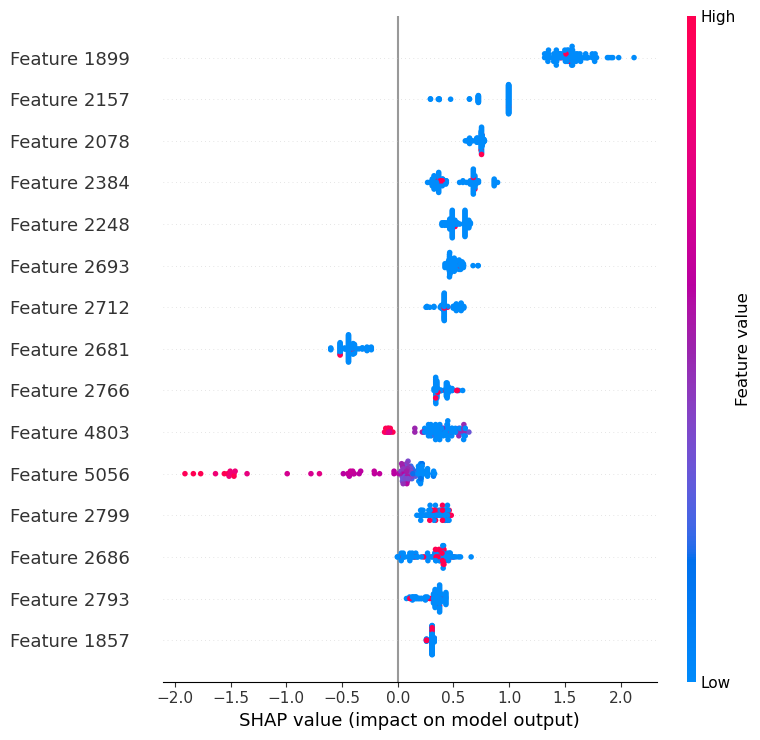

In [9]:
import shap
import joblib
import pandas as pd
from scipy.sparse import hstack, csr_matrix

# 📥 Load saved models
stack_model = joblib.load("app/model/stacking_model.pkl")
preprocessor = joblib.load("app/model/preprocessor.pkl")
tfidf_vectorizers = joblib.load("app/model/tfidf_vectorizers.pkl")

# 📄 Load data
data = pd.read_csv("../data/processed/balanced_data.csv")
X = data.drop("fraudulent", axis=1)
y = data["fraudulent"]

# 🎯 Sample small set for SHAP
X_sample = X.sample(100, random_state=42)

# 🧠 Check available columns
all_text_cols = ['description', 'company_profile', 'requirements', 'benefits']
text_cols = [col for col in all_text_cols if col in X.columns and col in tfidf_vectorizers]
non_text_cols = [col for col in X.columns if col not in text_cols]

# 🔄 Transform tabular data
X_tabular = preprocessor.transform(X_sample[non_text_cols])

# 🔠 Transform text using saved vectorizers
text_vectors = []
for col in text_cols:
    tfidf = tfidf_vectorizers[col]
    vec = tfidf.transform(X_sample[col].fillna(""))
    text_vectors.append(vec)

# 🔗 Combine tabular and text
X_text = hstack(text_vectors)
X_final = hstack([csr_matrix(X_tabular), X_text])

# ✅ Extract XGBoost model
xgb_model = stack_model.named_estimators_['xgb']

# 🧠 Convert to dense for SHAP
X_dense = X_final.toarray()

# 🌳 Tree explainer for XGBoost
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_dense)

# 📊 SHAP summary plot
shap.summary_plot(shap_values, X_dense, max_display=15)


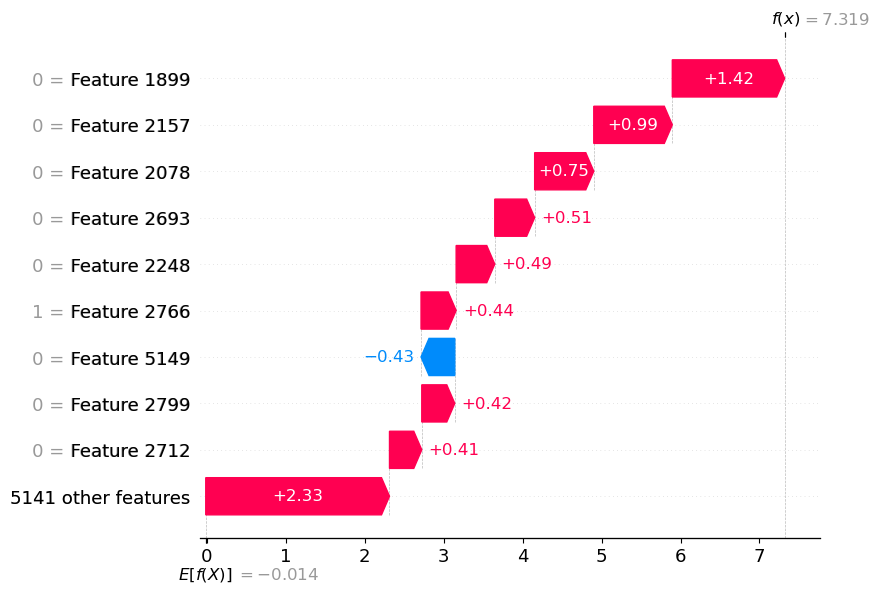

In [10]:
i = 0  # Index of the sample to explain
shap.plots.waterfall(shap.Explanation(values=shap_values[i], base_values=explainer.expected_value, data=X_dense[i]))


C:\Users\Admin\AppData\Local\Temp\ipykernel_1472\2949859818.py:4: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_dense, max_display=15, show=False)


✅ SHAP plot saved as shap_summary.png


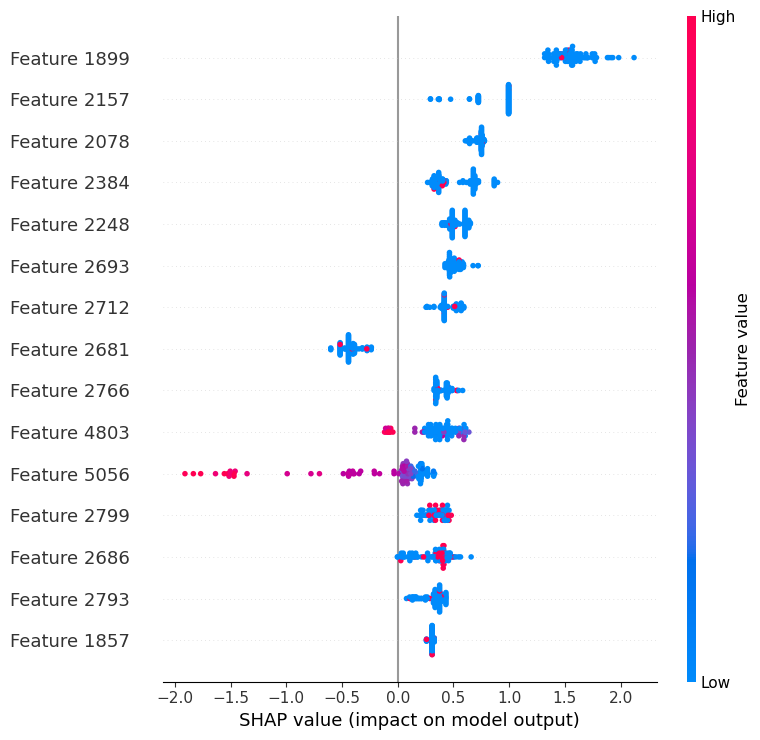

In [11]:
import matplotlib.pyplot as plt

plt.figure()
shap.summary_plot(shap_values, X_dense, max_display=15, show=False)
plt.savefig("shap_summary.png")
print("✅ SHAP plot saved as shap_summary.png")
